# Business context
Credit card fraud detection is a high-risk, low-frequency problem. Missing fraud is costly, but overly aggressive models can block legitimate customers.
The goal of this project is to predict fraud probability and explore decision thresholds that balance fraud detection with false positives.

In [221]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score, confusion_matrix, classification_report)
from xgboost import XGBClassifier

In [33]:
df_fraud = pd.read_excel('fraud_dataset.xlsx', skiprows=18)

In [ ]:
df_fraud_main = df_fraud.copy()
col_names = list(df_fraud_main["Unnamed: 0"][:8])
df_fraud_main.columns = col_names

df_fraud_main = df_fraud_main[10:].reset_index(drop=True)

df_fraud_main.columns = (
    df_fraud_main.columns
      .str.replace("@ATTRIBUTE", "", regex=False)
      .str.replace("REAL", "", regex=False)
      .str.replace("INTEGER", "", regex=False)
      .str.strip()
)
df_fraud_main["distance_from_home"] = df_fraud_main["distance_from_home"].astype(float)
df_fraud_main.head(5)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


#MISSING VALUE CHECK

In [209]:
df_fraud_main.describe()
df_fraud_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [210]:
df_fraud_main.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [218]:
def quantile(df1, col):
    df = df1.copy()
    for i in col:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)
        iqr = q3 - q1

        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        df[i] = df[i].clip(lower, upper)
    return df


In [213]:
test = quantile(df_fraud_main, cols)


3.8780079928249998   25.743985056550002
0.2966706421   3.355747690175
0.4756733234   2.096370265


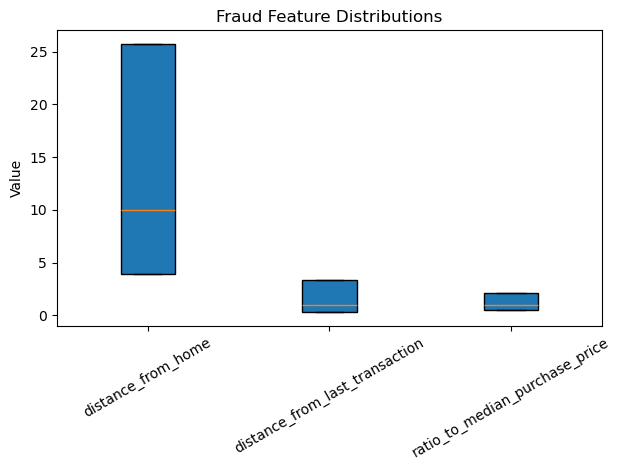

In [214]:
cols = ["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"]

data = [test[col] for col in cols]

plt.boxplot(data, vert=True, patch_artist=True)
plt.xticks(range(1, len(cols) + 1), cols, rotation=30)
plt.ylabel("Value")
plt.title("Fraud Feature Distributions")
plt.tight_layout()
plt.show()

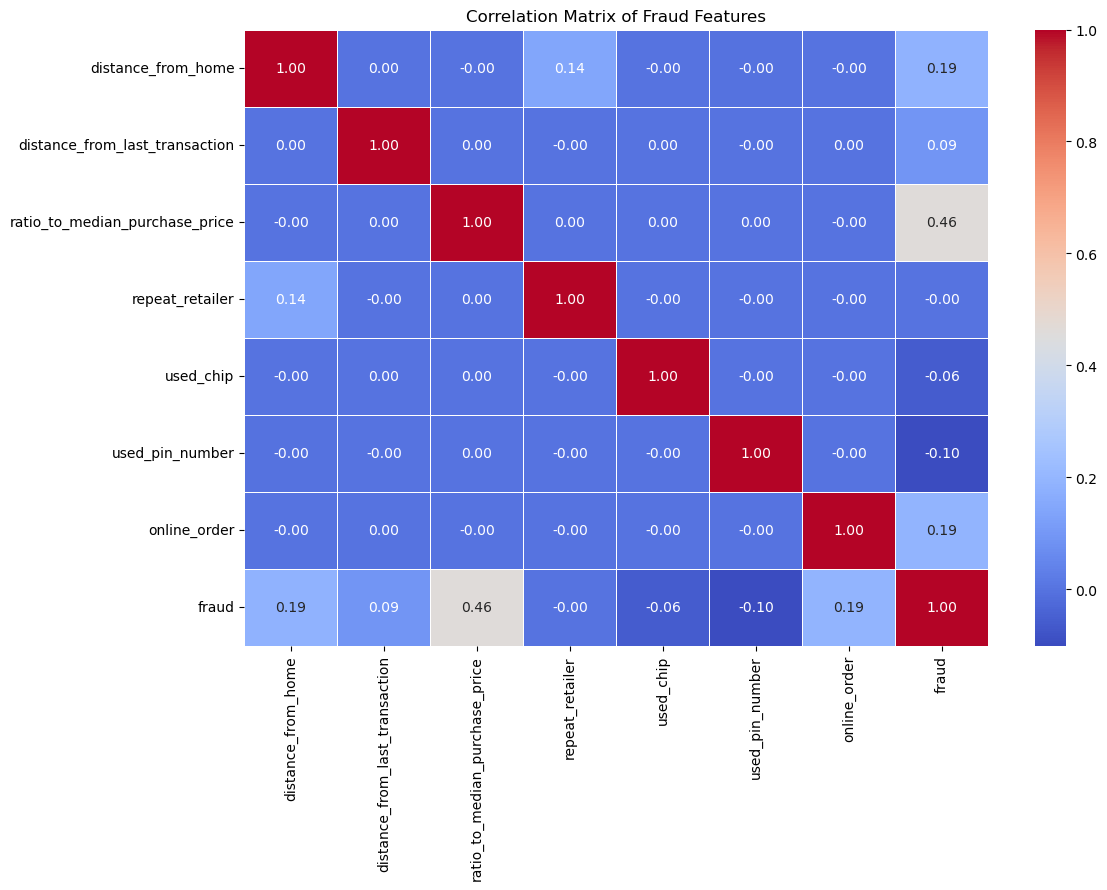

In [ ]:
corr_matrix = df_fraud_main.corr()

plt.figure(figsize=(12, 8))

#Draw the heatmap (corrgram)
sns.heatmap(corr_matrix, 
            annot=True,            # Shows the numerical correlation values
            fmt=".2f",             # Rounds to 2 decimal places
            cmap='coolwarm',       # Color scheme (Red = positive, Blue = negative)
            linewidths=0.5)

plt.title('Correlation Matrix of Fraud Features')
plt.show()

In [216]:
# Define features and target
X = df_fraud_main.drop('fraud', axis=1)
y = df_fraud_main['fraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the model
model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]
pred_05 = (proba >= 0.5).astype(int)

print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC:", round(average_precision_score(y_test, proba), 4))
print("\nConfusion Matrix (0.5):\n", confusion_matrix(y_test, pred_05))
print("\nReport (0.5):\n", classification_report(y_test, pred_05))

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:04:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC: 1.0
PR-AUC: 0.9997

Confusion Matrix (0.5):
 [[182325    194]
 [   155  17326]]

Report (0.5):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.99      0.99      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000



In [219]:
importance = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10)

online_order                      0.445539
ratio_to_median_purchase_price    0.160036
used_pin_number                   0.145227
repeat_retailer                   0.106986
used_chip                         0.099731
distance_from_home                0.030384
distance_from_last_transaction    0.012097
dtype: float32

Distance from home and transaction-related features appear among the strongest predictors, which aligns with expected fraud behaviour.

In [217]:
def evaluate_threshold(y_true, proba, threshold):
    pred = (proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(confusion_matrix(y_true, pred))
    print(classification_report(y_true, pred))

for t in [0.5, 0.3, 0.2, 0.1]:
    evaluate_threshold(y_test, proba, t)



Threshold: 0.5
[[182325    194]
 [   155  17326]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.99      0.99      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000


Threshold: 0.3
[[182187    332]
 [    65  17416]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.98      1.00      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000


Threshold: 0.2
[[182122    397]
 [    25  17456]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.98      1.00      0.99     17481

    accuracy                 

In [220]:
df_predict = df_fraud_main.tail(5000).copy()
X_pred = df_predict.drop(columns=["fraud"])

fraud_prob = model.predict_proba(X_pred)[:, 1]
threshold = 0.2
fraud_pred = (fraud_prob >= threshold).astype(int)

out = df_predict.copy()
out["fraud_probability"] = fraud_prob
out["fraud_prediction"] = fraud_pred

import os
os.makedirs("outputs", exist_ok=True)
out.to_csv("outputs/fraud_predictions_last5000.csv", index=False)

out.head()


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,fraud_probability,fraud_prediction
995000,15.021355,3.038293,1.249045,1.0,0.0,0.0,1.0,0.0,2.804609e-05,0
995001,31.519266,0.111906,3.421337,1.0,1.0,0.0,0.0,0.0,1.314330e-06,0
995002,28.190057,4.383197,0.143161,1.0,0.0,0.0,0.0,0.0,2.654105e-07,0
995003,15.779849,2.002079,2.044939,1.0,1.0,0.0,1.0,0.0,7.258287e-07,0
995004,11.526775,0.695771,1.804341,1.0,1.0,0.0,0.0,0.0,7.490461e-07,0


Lower thresholds increase fraud recall but also raise false positives. In practice, the threshold would be chosen based on operational capacity and customer impact.